In [1]:
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

# ==== 文件路径（按需修改）====
band_path = Path("band.txt")   # 你的 DFT 四条目标带文件
assert band_path.exists(), f"File not found: {band_path.resolve()}"

# ==== 如果 band.txt 没有减去 DFT 费米能级，就在这里填 Ef（单位 eV）====
# 若你确认已经对齐到 EF=0，则保持 Ef=0.0
Ef = 0.0


In [2]:
def load_dft_4bands_from_bandtxt(path, Ef=0.0, atol=1e-8):
    """
    Read band.txt with 4 blocks, each block has 2 columns:
      kdist  energy
    Returns:
      kdist: (Nk,)
      E4:    (Nk,4) energies (after subtracting Ef), sorted low->high per-k.
    """
    path = Path(path)
    blocks = []
    cur = []

    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("#"):
                if cur:
                    blocks.append(cur)
                    cur = []
                continue

            parts = re.split(r"[,\s\t]+", s)
            if len(parts) < 2:
                continue
            try:
                x = float(parts[0])
                y = float(parts[1])
                cur.append((x, y))
            except ValueError:
                continue

    if cur:
        blocks.append(cur)

    if len(blocks) != 4:
        raise ValueError(f"Expect 4 blocks (4 bands), got {len(blocks)} blocks.")

    # reference x from band-1 block
    x_ref = np.array([p[0] for p in blocks[0]], dtype=float)

    energies = []
    for bi, b in enumerate(blocks):
        x = np.array([p[0] for p in b], dtype=float)
        e = np.array([p[1] for p in b], dtype=float)

        # if mostly decreasing, reverse
        if np.mean(np.diff(x) > 0) < 0.5:
            x = x[::-1]
            e = e[::-1]

        if x.shape != x_ref.shape or not np.allclose(x, x_ref, rtol=0, atol=atol):
            raise ValueError(f"kdist mismatch in block {bi+1}.")
        energies.append(e)

    kdist = x_ref
    E4 = np.column_stack(energies) - Ef

    # ensure per-k energy ordering low->high (robust to band crossing / index issues)
    E4 = np.sort(E4, axis=1)

    return kdist, E4

kdist, dft_bands = load_dft_4bands_from_bandtxt(band_path, Ef=Ef)

print("kdist:", kdist.shape, "range:", (kdist.min(), kdist.max()))
print("dft_bands:", dft_bands.shape, "E-range:", (dft_bands.min(), dft_bands.max()))


kdist: (80,) range: (np.float64(0.0), np.float64(3.01857))
dft_bands: (80, 4) E-range: (np.float64(-0.63362), np.float64(0.93492))


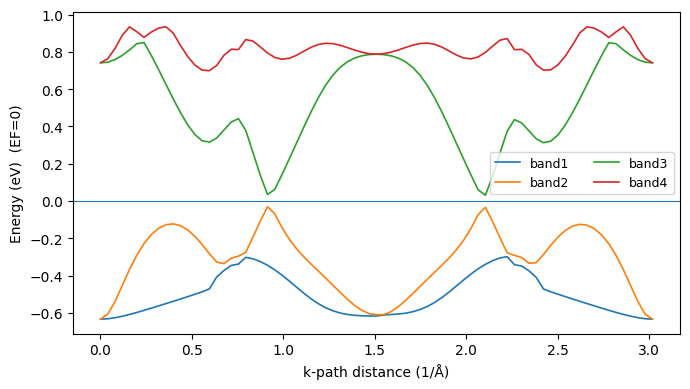

In [3]:
plt.figure(figsize=(7, 4))
for i in range(4):
    plt.plot(kdist, dft_bands[:, i], lw=1.2, label=f"band{i+1}")
plt.axhline(0.0, lw=0.8)
plt.xlabel("k-path distance (1/Å)")
plt.ylabel("Energy (eV)  (EF=0)")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


In [4]:
out = Path("dft_4bands.npz")
np.savez(out, kdist=kdist, dft_bands=dft_bands, Ef_used=Ef)
print("Saved:", out.resolve())


Saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\ML\dft_4bands.npz


In [5]:
import numpy as np

# 高对称点（fractional coordinates）
G = np.array([0.0, 0.0])
X = np.array([0.5, 0.0])
M = np.array([0.5, 0.5])
Y = np.array([0.0, 0.5])

k_nodes = [G, X, M, Y, G]
k_labels = [r"$\Gamma$", r"$X$", r"$M$", r"$Y$", r"$\Gamma$"]

# 你给定：每段插 20 点（注意：你的 band.txt 实际对应“每段 20 个点，端点重复”）
points_per_seg = 20

def build_kpath(nodes, points_per_seg=20, keep_duplicate_endpoints=True):
    """
    nodes: list of high-sym k-points (fractional)
    points_per_seg: number of points per segment (including endpoints)
    keep_duplicate_endpoints:
      - True: keep segment endpoints duplicated (matches your DFT band.txt style)
      - False: drop the first point of each subsequent segment to avoid duplicates
    """
    kpts = []
    for i in range(len(nodes) - 1):
        a, b = np.array(nodes[i]), np.array(nodes[i + 1])
        seg = np.linspace(a, b, points_per_seg, endpoint=True)  # points_per_seg points
        if (i > 0) and (not keep_duplicate_endpoints):
            seg = seg[1:]  # remove duplicate joint
        kpts.append(seg)
    return np.vstack(kpts)

print("Cell 6 ready.")


Cell 6 ready.


In [6]:
Nk_dft = dft_bands.shape[0]
print("Nk from DFT:", Nk_dft)

# 判断 DFT kdist 是否存在“端点重复”（段连接处出现 kdist 不变）
has_duplicates = np.any(np.isclose(np.diff(kdist), 0.0, atol=1e-12))
print("DFT kdist has duplicate joints:", has_duplicates)

if has_duplicates:
    # 你的数据属于这种：每段 points_per_seg 个点，端点重复
    # 总点数 Nk = 4 * points_per_seg
    if Nk_dft % 4 != 0:
        raise ValueError(f"DFT Nk={Nk_dft} not divisible by 4, cannot infer points_per_seg.")
    points_per_seg_auto = Nk_dft // 4
    keep_dup = True
    Nk_expected = 4 * points_per_seg_auto
else:
    # 如果没有重复端点：Nk = 4*points_per_seg - 3（因为 3 个连接点不重复）
    if (Nk_dft + 3) % 4 != 0:
        raise ValueError(f"DFT Nk={Nk_dft} not compatible with 4 segments (no-dup mode).")
    points_per_seg_auto = (Nk_dft + 3) // 4
    keep_dup = False
    Nk_expected = 4 * points_per_seg_auto - 3

print("Inferred points_per_seg:", points_per_seg_auto)
print("keep_duplicate_endpoints:", keep_dup)
print("Nk expected:", Nk_expected)

# 用推断值生成 k 点
points_per_seg = int(points_per_seg_auto)
kpts_frac = build_kpath(k_nodes, points_per_seg=points_per_seg, keep_duplicate_endpoints=keep_dup)

print("Final points_per_seg:", points_per_seg)
print("Final kpts_frac shape:", kpts_frac.shape)

assert kpts_frac.shape[0] == Nk_dft, "k-point count must match DFT bands."


Nk from DFT: 80
DFT kdist has duplicate joints: True
Inferred points_per_seg: 20
keep_duplicate_endpoints: True
Nk expected: 80
Final points_per_seg: 20
Final kpts_frac shape: (80, 2)


In [7]:
# 用 fractional 坐标生成一个相对 kdist（仅用于绘图对齐）
dk = np.diff(kpts_frac, axis=0)
kdist_tb = np.r_[0.0, np.cumsum(np.linalg.norm(dk, axis=1))]

# 线性映射到 DFT 的 kdist 范围（保证绘图 x 轴对齐）
kdist_tb_scaled = (kdist_tb / kdist_tb[-1]) * (kdist[-1] - kdist[0]) + kdist[0]

print("kdist DFT range:", (float(kdist[0]), float(kdist[-1])))
print("kdist TB  range:", (float(kdist_tb_scaled[0]), float(kdist_tb_scaled[-1])))
print("Check duplicates in TB kdist:", np.any(np.isclose(np.diff(kdist_tb_scaled), 0.0, atol=1e-12)))


kdist DFT range: (0.0, 3.01857)
kdist TB  range: (0.0, 3.01857)
Check duplicates in TB kdist: True


In [8]:
def band_loss(tb_bands, dft_bands, ewin=0.5):
    """
    tb_bands, dft_bands: (Nk,4), energies aligned to EF=0
    Soft weights: inside window=1, outside=0.1
    """
    w = np.where(np.abs(dft_bands) <= ewin, 1.0, 0.1)
    return float(np.sqrt(np.mean(w * (tb_bands - dft_bands)**2)))

print("band_loss test (DFT vs DFT) =", band_loss(dft_bands, dft_bands, ewin=0.5))


band_loss test (DFT vs DFT) = 0.0


In [9]:
def tb_bands_from_model(model, kpts_frac):
    """
    model: pythtb.tb_model (4-band, 2D)
    kpts_frac: (Nk,2) fractional k points
    return: (Nk,4) sorted eigenvalues
    """
    Nk = kpts_frac.shape[0]
    out = np.zeros((Nk, 4), dtype=float)
    for i, kpt in enumerate(kpts_frac):
        evals = np.array(model.solve_all(kpt), dtype=float).ravel()
        if evals.size != 4:
            raise ValueError(f"Expect 4 eigenvalues, got {evals.size}")
        out[i] = np.sort(evals)
    return out

# ====== 你需要实现 build_model(params) ======
# def build_model(params):
#     ...
#     return model

# params = dict(e1=..., e2=..., t1=..., t2=..., t3=..., t4=...)
# model = build_model(params)
# tb_bands = tb_bands_from_model(model, kpts_frac)
# L = band_loss(tb_bands, dft_bands, ewin=0.5)
# print("L_band =", L)


In [10]:
import matplotlib.pyplot as plt

def plot_compare(dft_bands, tb_bands, x_axis, title="DFT vs TB (4 bands)"):
    plt.figure(figsize=(7,4))
    for j in range(4):
        plt.plot(x_axis, dft_bands[:, j], lw=1.2, label=f"DFT b{j+1}" if j==0 else None)
        plt.plot(x_axis, tb_bands[:, j], lw=1.0, linestyle="--", label=f"TB b{j+1}" if j==0 else None)
    plt.axhline(0.0, lw=0.8)
    plt.ylim(-0.5, 0.5)
    plt.xlabel("k-path distance (1/Å)")
    plt.ylabel("Energy (eV)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 推荐用 DFT 的 kdist 直接做 x 轴（完全一致）
# plot_compare(dft_bands, tb_bands, kdist, title="DFT vs TB (EF±0.5 eV)")


In [11]:
###计算拟合损失

import numpy as np
from pathlib import Path

# 7 个基 hr 文件（你按实际文件名修改）
HR_FILES = {
    "0":  Path("hr_0.dat"),
    "e1": Path("hr_e1.dat"),
    "e2": Path("hr_e2.dat"),
    "t1": Path("hr_t1.dat"),
    "t2": Path("hr_t2.dat"),
    "t3": Path("hr_t3.dat"),
    "t4": Path("hr_t4.dat"),
}

for k, p in HR_FILES.items():
    assert p.exists(), f"Missing {k}: {p.resolve()}"
print("All basis HR files found.")


All basis HR files found.


In [12]:
def read_wannier90_hr_to_dict(path: Path):
    lines = path.read_text(encoding="utf-8", errors="ignore").splitlines()
    lines = [ln.strip() for ln in lines if ln.strip()]
    norb = int(lines[1])
    nR = int(lines[2])

    # degeneracies lines
    deg = []
    idx = 3
    while len(deg) < nR:
        deg.extend([int(x) for x in lines[idx].split()])
        idx += 1

    hop = {}
    for ln in lines[idx:]:
        parts = ln.split()
        if len(parts) < 7:
            continue
        Rx, Ry, Rz = int(parts[0]), int(parts[1]), int(parts[2])
        i = int(parts[3]) - 1
        j = int(parts[4]) - 1
        re_val = float(parts[5])
        im_val = float(parts[6])
        hop[((Rx, Ry, Rz), i, j)] = re_val + 1j * im_val

    return norb, hop

# 读一个看看
norb0, hop0 = read_wannier90_hr_to_dict(HR_FILES["0"])
print("norb =", norb0, "num terms =", len(hop0))
assert norb0 == 4, "请确保基 hr 文件确实是 4 带模型（norb=4）"


norb = 4 num terms = 112


In [13]:
basis = {}
norb_ref = None
keys_ref = None

for name, path in HR_FILES.items():
    norb, hop = read_wannier90_hr_to_dict(path)
    if norb_ref is None:
        norb_ref = norb
        keys_ref = set(hop.keys())
    else:
        if norb != norb_ref:
            raise ValueError(f"norb mismatch in {name}: {norb} vs {norb_ref}")
        if set(hop.keys()) != keys_ref:
            raise ValueError(f"HR sparsity pattern mismatch in {name}. "
                             f"Make sure all basis HR files export the same (R,i,j) set.")
    basis[name] = hop

print("Loaded 7 basis HR dicts. keys =", len(keys_ref))


Loaded 7 basis HR dicts. keys = 112


In [14]:
PARAMS = ["e1", "e2", "t1", "t2", "t3", "t4"]

def combine_hop(params):
    """
    params: dict with keys e1,e2,t1..t4 (float)
    return: hop_dict for this params
    """
    hop = {}
    for key in keys_ref:
        v = basis["0"][key]
        for p in PARAMS:
            v = v + float(params[p]) * basis[p][key]
        hop[key] = v
    return hop


In [ ]:
# ===== 晶格（2D 四方，单位 Å）=====
a0 = 4.1630263607523368

lat_vecs = [
    [a0, 0.0],
    [0.0, a0],
]

# ===== 轨道中心（分数坐标）=====
# 2 个磁性原子 × dz2 × (up, dn)
orb_vecs = [
    [0.5, 0.0],  # atom A, dz2 ↑
    [0.0, 0.5],  # atom B, dz2 ↑
    [0.5, 0.0],  # atom A, dz2 ↓
    [0.0, 0.5],  # atom B, dz2 ↓
]


In [ ]:
import numpy as np

def tb_bands_from_model(model, kpts_frac):
    """
    Robust for your pythtb build:
    - DO NOT call solve_all (it passes k_list kw and breaks)
    - Call solve_ham with POSITIONAL args only
    """
    Nk = kpts_frac.shape[0]
    out = np.zeros((Nk, 4), dtype=float)

    for i, kpt in enumerate(kpts_frac):
        # 关键：solve_ham 的第一个参数用位置参数传入，避免 k_pts / k_list 关键字不兼容
        evals = model.solve_ham([kpt], False)   # 等价于 return_eigvecs=False
        
        evals = np.asarray(evals).squeeze()
        # 常见形状：(4,) 或 (1,4) -> squeeze 后变 (4,)
        if evals.ndim != 1:
            evals = evals.reshape(-1)

        if evals.size != 4:
            raise ValueError(f"Expect 4 eigenvalues, got {evals.size} at k-index {i}")

        out[i] = np.sort(evals.astype(float))

    return out


In [17]:
def tb_bands_from_model(model, kpts_frac):
    Nk = kpts_frac.shape[0]
    out = np.zeros((Nk, 4), dtype=float)
    for i, kpt in enumerate(kpts_frac):
        evals = np.array(model.solve_ham(kpt), dtype=float).ravel()
        out[i] = np.sort(evals)
    return out

def band_loss(tb_bands, dft_bands, ewin=0.5):
    w = np.where(np.abs(dft_bands) <= ewin, 1.0, 0.1)
    return float(np.sqrt(np.mean(w * (tb_bands - dft_bands)**2)))


In [18]:
params_test = {"e1":0.2,"e2":-0.1,"t1":0.3,"t2":-0.2,"t3":0.0,"t4":0.15}

hop_test = combine_hop(params_test)
model_test = build_pythtb(lat_vecs, orb_vecs, hop_test)

tb_bands = tb_bands_from_model(model_test, kpts_frac)
L = band_loss(tb_bands, dft_bands, ewin=0.5)
print("L_band =", L)



NameError: name 'build_pythtb' is not defined

In [ ]:
EWIN = 0.5

def compute_gap_min(bands):
    # bands: (Nk,4) sorted per k
    vbm = np.max(bands[:, 1])   # 第二条：价带顶（2条价带）
    cbm = np.min(bands[:, 2])   # 第三条：导带底（2条导带）
    return float(cbm - vbm)

def evaluate(params, do_chern=False):
    hop = combine_hop(params)
    model = build_pythtb(lat_vecs, orb_vecs, hop)
    tb_bands = tb_bands_from_model(model, kpts_frac)
    L = band_loss(tb_bands, dft_bands, ewin=EWIN)
    gap = compute_gap_min(tb_bands)

    C = None
    if do_chern:
        # 这里后面接你的 WFArray.chern_number（occ=[0,1]）
        C = chern_occ_2bands(model)  # 先写成占位函数，下一步实现

    return L, gap, C


In [ ]:
import optuna
import numpy as np

PARAMS = ["e1","e2","t1","t2","t3","t4"]

def objective(trial):
    params = {p: trial.suggest_float(p, -1.0, 1.0) for p in PARAMS}

    L, gap, _ = evaluate(params, do_chern=False)
    trial.set_user_attr("gap", gap)

    # 可选：对近金属态惩罚，避免拟合“钻空子”
    gap_floor = 1e-3
    if gap < gap_floor:
        return L + 10.0  # 惩罚力度可调

    # 可选：当拟合足够好时才算陈数并记录（省算力）
    if L < 0.10:  # 你后面根据实际 L 的量级调
        try:
            C = chern_occ_2bands_from_hopdict(params)  # 下一步实现
            trial.set_user_attr("chern", int(C))
        except Exception as e:
            trial.set_user_attr("chern_error", str(e))

    return L

study = optuna.create_study(
    study_name="fit_EFpm0p5",
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage="sqlite:///optuna_tbfit.db",
    load_if_exists=True
)

study.optimize(objective, n_trials=2000, n_jobs=1)

print("Best L:", study.best_value)
print("Best params:", study.best_params)
print("Best trial attrs:", study.best_trial.user_attrs)


c:\ProgramData\Miniconda3\envs\pythtb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-07 01:36:40,910] A new study created in RDB with name: fit_EFpm0p5
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)
[I 2026-01-07 01:36:41,642] Trial 0 finished with value: 0.8151184221104946 and parameters: {'e1': -0.250919762305275, 'e2': 0.9014286128198323, 't1': 0.4639878836228102, 't2': 0.1973169683940732, 't3': -0.687962719115127, 't4': -0.6880109593275947}. Best is trial 0 with value: 0.8151184221104946.
[I 2026-01-07 01:36:42,305] Trial 1 finished with value: 1.3796589148211615 and parameters: {'e1': -0.883832775663601

Best L: 0.07820996955495832
Best params: {'e1': 0.5785535266736205, 'e2': -0.280573151186815, 't1': 0.11650524174535232, 't2': -0.06973376149849093, 't3': 0.03448064935523084, 't4': -0.08354095776063084}
Best trial attrs: {'chern_error': "name 'chern_occ_2bands_from_hopdict' is not defined", 'gap': 0.4422690344455483}


In [ ]:
#####计算陈数

import numpy as np
from pythtb import Mesh, WFArray

def make_mesh_2d_grid(Nk=31, gamma_centered=True):
    """
    Create a 2D k-mesh compatible with multiple pythtb builds.
    """
    # 先尝试你 notebook 里用过的构造方式：Mesh(["k","k"])
    try:
        mesh = Mesh(["k", "k"])
        mesh.build_grid((Nk, Nk), gamma_centered=gamma_centered)
        return mesh
    except Exception:
        pass

    # 兼容另一种签名：Mesh(axis_types=[...], dim_k=...)
    mesh = Mesh(axis_types=["k", "k"], dim_k=2)
    mesh.build_grid((Nk, Nk), gamma_centered=gamma_centered)
    return mesh


In [ ]:
def estimate_gap_min_on_grid(model, Nk=21, gamma_centered=True):
    """
    Estimate global min gap between band #2 and #3 (index 1 and 2) on a 2D grid.
    For a 4-band model with 2 valence + 2 conduction, this is the relevant gap.
    """
    mesh = make_mesh_2d_grid(Nk=Nk, gamma_centered=gamma_centered)

    # mesh.points 在不同版本里形状可能不同：这里做稳健 flatten
    pts = np.asarray(mesh.points)
    pts = pts.reshape(-1, 2)

    gap_min = np.inf
    for kpt in pts:
        # 用 solve_ham 的“位置参数”调用，避免 k_list 关键字兼容问题
        evals = model.solve_ham([kpt], False)
        evals = np.asarray(evals).squeeze()
        if evals.ndim != 1:
            evals = evals.reshape(-1)
        evals = np.sort(evals.astype(float))
        if evals.size != 4:
            raise ValueError(f"Expect 4 bands, got {evals.size}")

        gap_k = evals[2] - evals[1]  # conduction bottom - valence top
        if gap_k < gap_min:
            gap_min = gap_k

    return float(gap_min)


In [ ]:
def chern_valence_2bands(model, Nk_chern=31, Nk_gap=21, gap_floor=5e-3, gamma_centered=True):
    """
    Compute Chern number for the 2 occupied (valence) bands in a 4-band 2D model:
      occ = [0, 1]
    Returns:
      (Chern_float, gap_min_grid)
    If gap_min_grid < gap_floor, returns (None, gap_min_grid).
    """
    gap_min = estimate_gap_min_on_grid(model, Nk=Nk_gap, gamma_centered=gamma_centered)
    if gap_min < gap_floor:
        return None, gap_min

    mesh = make_mesh_2d_grid(Nk=Nk_chern, gamma_centered=gamma_centered)
    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    C = wfa.chern_number(state_idx=[0, 1], plane=(0, 1))
    C = float(np.asarray(C).squeeze())
    return C, gap_min


In [ ]:
# 你已跑通的那套参数测试
params_test = {"e1":0.2,"e2":-0.1,"t1":0.3,"t2":-0.2,"t3":0.0,"t4":0.15}

hop_test = combine_hop(params_test)
model_test = build_pythtb(lat_vecs, orb_vecs, hop_test)

C, gap_min = chern_valence_2bands(model_test, Nk_chern=21, Nk_gap=21, gap_floor=5e-3)
print("gap_min_grid =", gap_min, "eV")
print("Chern(valence 2 bands) =", C)


gap_min_grid = 0.022940410206612763 eV
Chern(valence 2 bands) = 8.834874115176436e-17


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


In [ ]:
for Nk in [21, 31, 41, 51]:
    C, gap_min = chern_valence_2bands(model_test, Nk_chern=Nk, Nk_gap=21, gap_floor=5e-3)
    print(f"Nk_chern={Nk:2d}  gap_min={gap_min:.6f} eV   Chern={C}")


Nk_chern=21  gap_min=0.022940 eV   Chern=8.834874115176436e-17
Nk_chern=31  gap_min=0.022940 eV   Chern=-7.067899292141149e-17
Nk_chern=41  gap_min=0.022940 eV   Chern=-3.533949646070574e-17
Nk_chern=51  gap_min=0.022940 eV   Chern=3.533949646070574e-17


In [ ]:
import numpy as np

PARAMS = ["e1","e2","t1","t2","t3","t4"]
EWIN = 0.5

def eval_point(params, do_chern=True, Nk_chern=31, Nk_gap=21, gap_floor=5e-3):
    """
    params: dict with keys in PARAMS
    return dict with L_band, gap_path, gap_grid, chern (int/None), chern_raw
    """
    # TB bands on k-path (for fitting)
    hop = combine_hop(params)
    model = build_pythtb(lat_vecs, orb_vecs, hop)
    tb_bands = tb_bands_from_model(model, kpts_frac)

    L = band_loss(tb_bands, dft_bands, ewin=EWIN)
    gap_path = compute_gap_min(tb_bands)

    out = {
        "L": float(L),
        "gap_path": float(gap_path),
        "gap_grid": None,
        "chern": None,
        "chern_raw": None,
        "params": dict(params),
    }

    if do_chern:
        C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
            params, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.25
        )
        out["gap_grid"] = float(gap_grid)
        out["chern"] = C_int
        out["chern_raw"] = C_raw

    return out


In [ ]:
import random
from copy import deepcopy

best_params = {'e1': 0.5785535266736205, 'e2': -0.280573151186815, 't1': 0.11650524174535232,
               't2': -0.06973376149849093, 't3': 0.03448064935523084, 't4': -0.08354095776063084}

def clip01(x):
    return float(np.clip(x, -1.0, 1.0))

def random_params():
    return {p: random.uniform(-1, 1) for p in PARAMS}

def jitter_params(center, sigma=0.15):
    # 在 center 周围做高斯扰动，再裁剪到 [-1,1]
    out = {}
    for p in PARAMS:
        out[p] = clip01(center[p] + np.random.normal(0, sigma))
    return out

# 你可以按当前拟合水平调阈值：
L_th = 0.10          # 只关注拟合足够好的点
gap_floor = 5e-3     # 网格最小能隙阈值（eV）
Nk_chern = 31
Nk_gap = 21

results = []
found_nontrivial = []

# ---- Stage A: 全局随机探索 ----
N_rand = 300  # 可增大到 1000
for _ in range(N_rand):
    params = random_params()
    r = eval_point(params, do_chern=True, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor)
    results.append(r)
    if (r["L"] < L_th) and (r["chern"] is not None) and (r["chern"] != 0):
        found_nontrivial.append(r)

print(f"Random explored: {N_rand}, nontrivial found (L<{L_th}): {len(found_nontrivial)}")

# ---- Stage B: 围绕 best_params 局部探索（更容易保持拟合好）----
N_local = 400
for _ in range(N_local):
    params = jitter_params(best_params, sigma=0.12)  # sigma 可调：0.08~0.25
    r = eval_point(params, do_chern=True, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor)
    results.append(r)
    if (r["L"] < L_th) and (r["chern"] is not None) and (r["chern"] != 0):
        found_nontrivial.append(r)

print(f"Local explored: {N_local}, total nontrivial found (L<{L_th}): {len(found_nontrivial)}")

# 汇总最好的若干点看看
def sort_key(r): 
    return (r["L"], -abs(r["chern"] or 0), -(r["gap_grid"] or -1))

top = sorted(results, key=lambda r: r["L"])[:10]
print("\nTop-10 by L:")
for r in top:
    print(f"L={r['L']:.4f}, gap_grid={r['gap_grid']}, chern={r['chern']}, gap_path={r['gap_path']:.4f}")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


Random explored: 300, nontrivial found (L<0.1): 0
Local explored: 400, total nontrivial found (L<0.1): 0

Top-10 by L:
L=0.0881, gap_grid=0.33489250597673825, chern=0, gap_path=0.3279
L=0.0901, gap_grid=0.5418907888378645, chern=0, gap_path=0.5374
L=0.0971, gap_grid=0.5689503072908196, chern=0, gap_path=0.5654
L=0.1001, gap_grid=0.5740584674846654, chern=0, gap_path=0.5726
L=0.1002, gap_grid=0.4797737499426338, chern=0, gap_path=0.4784
L=0.1009, gap_grid=0.60984964710782, chern=0, gap_path=0.6086
L=0.1014, gap_grid=0.599444273241279, chern=0, gap_path=0.5409
L=0.1018, gap_grid=0.45089283926465296, chern=0, gap_path=0.4401
L=0.1029, gap_grid=0.596415031027668, chern=0, gap_path=0.5940
L=0.1054, gap_grid=0.530089703409104, chern=0, gap_path=0.5234


In [ ]:
# 找一个拟合好且 C=0 的点（默认用 best_params）
r0 = eval_point(best_params, do_chern=True, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor)
print("Anchor (best) :", "L=", r0["L"], "gap_grid=", r0["gap_grid"], "chern=", r0["chern"])

# 找一个非平庸点
if len(found_nontrivial) == 0:
    raise RuntimeError("没有找到 chern!=0 的点。请增大 N_rand/N_local，或增大 sigma，或放宽 L_th。")

# 选 L 最小的一个非平庸点
r1 = sorted(found_nontrivial, key=lambda r: r["L"])[0]
print("Nontrivial cand:", "L=", r1["L"], "gap_grid=", r1["gap_grid"], "chern=", r1["chern"])


Anchor (best) : L= 0.07820996955495832 gap_grid= 0.44633037325839076 chern= 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


RuntimeError: 没有找到 chern!=0 的点。请增大 N_rand/N_local，或增大 sigma，或放宽 L_th。

In [ ]:
import pandas as pd

def lerp_params(p0, p1, lam):
    out = {}
    for k in PARAMS:
        out[k] = clip01((1.0-lam)*p0[k] + lam*p1[k])
    return out

# 扫描密度：先粗扫，再细扫（自动）
n_coarse = 41
lams = np.linspace(0, 1, n_coarse)

rows = []
for lam in lams:
    params = lerp_params(r0["params"], r1["params"], lam)
    rr = eval_point(params, do_chern=True, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor)
    rows.append({
        "lam": float(lam),
        "L": rr["L"],
        "gap_path": rr["gap_path"],
        "gap_grid": rr["gap_grid"],
        "chern": rr["chern"],
        "chern_raw": rr["chern_raw"],
        **rr["params"]
    })

df = pd.DataFrame(rows)
display(df.head())
display(df.tail())

# 寻找陈数变化的位置
df_valid = df.dropna(subset=["chern"]).copy()
df_valid["chern"] = df_valid["chern"].astype(int)

change_idx = np.where(df_valid["chern"].values[1:] != df_valid["chern"].values[:-1])[0]
if len(change_idx) == 0:
    print("在这条连线上没有检测到陈数变化（可能相界不在连线上，或中间 gap_floor 过滤掉了关键点）。")
else:
    i0 = int(change_idx[0])
    a = df_valid.iloc[i0]
    b = df_valid.iloc[i0+1]
    print("Detected Chern change between:")
    print(a[["lam","chern","L","gap_grid"]])
    print(b[["lam","chern","L","gap_grid"]])

# 保存结果
out_csv = "line_scan_phase_boundary.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


In [ ]:
def refine_boundary(pA, pB, CA, CB, rounds=10):
    """
    二分细化：在 pA(CA) 与 pB(CB) 之间逼近 chern 翻转点
    """
    lamA, lamB = 0.0, 1.0
    rA = eval_point(pA, do_chern=True, Nk_chern=51, Nk_gap=31, gap_floor=5e-3)  # 细化用更密网格
    rB = eval_point(pB, do_chern=True, Nk_chern=51, Nk_gap=31, gap_floor=5e-3)

    if rA["chern"] is None or rB["chern"] is None or rA["chern"] == rB["chern"]:
        raise ValueError("Refine requires two endpoints with different well-defined chern.")

    for _ in range(rounds):
        lamM = 0.5*(lamA + lamB)
        pM = {k: 0.5*(pA[k] + pB[k]) for k in PARAMS}
        pM = {k: clip01(pM[k]) for k in PARAMS}
        rM = eval_point(pM, do_chern=True, Nk_chern=51, Nk_gap=31, gap_floor=5e-3)

        if rM["chern"] is None:
            # 如果中点 gap 太小，优先缩小区间（向 gap 更大的那边靠）
            # 简单策略：比较两端 gap_grid
            if (rA["gap_grid"] or 0) >= (rB["gap_grid"] or 0):
                pB, rB, lamB = pM, rM, lamM
            else:
                pA, rA, lamA = pM, rM, lamM
            continue

        if rM["chern"] == rA["chern"]:
            pA, rA, lamA = pM, rM, lamM
        else:
            pB, rB, lamB = pM, rM, lamM

    return {"left": (lamA, rA), "right": (lamB, rB)}

# 只有检测到翻转时才细化
if len(change_idx) > 0:
    # 用 coarse scan 中翻转相邻的两点作为端点
    a = df_valid.iloc[int(change_idx[0])]
    b = df_valid.iloc[int(change_idx[0])+1]

    pA = {k: float(a[k]) for k in PARAMS}
    pB = {k: float(b[k]) for k in PARAMS}
    CA, CB = int(a["chern"]), int(b["chern"])

    refined = refine_boundary(pA, pB, CA, CB, rounds=12)
    lamL, rL = refined["left"]
    lamR, rR = refined["right"]

    print("\nRefined boundary bracket:")
    print("Left :", "chern=", rL["chern"], "gap_grid=", rL["gap_grid"], "L=", rL["L"])
    print("Right:", "chern=", rR["chern"], "gap_grid=", rR["gap_grid"], "L=", rR["L"])


NameError: name 'change_idx' is not defined

In [ ]:
import numpy as np
import random

def max_imag_in_hopdict(hop_dict):
    vals = np.array(list(hop_dict.values()), dtype=np.complex128)
    return float(np.max(np.abs(np.imag(vals))))

def sample_max_imag(n=50):
    mx = 0.0
    mx_params = None
    for _ in range(n):
        params = {p: random.uniform(-1, 1) for p in PARAMS}
        hop = combine_hop(params)
        m = max_imag_in_hopdict(hop)
        if m > mx:
            mx = m
            mx_params = params
    return mx, mx_params

mx_imag, p_star = sample_max_imag(n=80)
print("Max |Im(hop)| over samples =", mx_imag)
print("params achieving it (approx) =", p_star)


Max |Im(hop)| over samples = 0.9999254467975405
params achieving it (approx) = {'e1': -0.6486264087008751, 'e2': -0.6324481970034299, 't1': 0.7323574409447497, 't2': -0.9999254467975405, 't3': -0.9457210661181983, 't4': -0.2133512243767557}


In [ ]:
def search_any_nontrivial(N=800, gap_floor=1e-4, Nk_chern=31, Nk_gap=21):
    hits = []
    for i in range(N):
        params = {p: random.uniform(-1, 1) for p in PARAMS}
        C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
            params, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.25
        )
        if (C_int is not None) and (C_int != 0):
            # 再算一次 L 作为参考（不用于过滤）
            r = eval_point(params, do_chern=False)
            hits.append({
                "params": params,
                "chern": C_int,
                "chern_raw": C_raw,
                "gap_grid": gap_grid,
                "L": r["L"],
                "gap_path": r["gap_path"],
            })
    return hits

hits = search_any_nontrivial(N=1000, gap_floor=1e-4, Nk_chern=31, Nk_gap=21)
print("Nontrivial hits found =", len(hits))
if len(hits) > 0:
    best_hit = sorted(hits, key=lambda x: x["L"])[0]
    print("Best-L nontrivial hit:")
    print(best_hit)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


Nontrivial hits found = 308
Best-L nontrivial hit:
{'params': {'e1': 0.942006045353804, 'e2': 0.057979138758178284, 't1': 0.04449830482364625, 't2': 0.3271430360887615, 't3': -0.03464578718223521, 't4': -0.18894337022093}, 'chern': 2, 'chern_raw': 2.0000000000000004, 'gap_grid': 0.0034040876206966053, 'L': 0.23982119085388653, 'gap_path': 0.0069899564046879414}


In [ ]:
import numpy as np

def jitter_params(center, sigma):
    out = {}
    for p in PARAMS:
        out[p] = float(np.clip(center[p] + np.random.normal(0, sigma), -1.0, 1.0))
    return out

def find_nontrivial_under_fit(best_params, stages):
    """
    stages: list of dicts, each has:
      N_rand, N_local, L_th, sigma, gap_floor
    """
    for st in stages:
        N_rand = st["N_rand"]
        N_local = st["N_local"]
        L_th = st["L_th"]
        sigma = st["sigma"]
        gap_floor = st.get("gap_floor", 1e-4)

        found = []

        # random
        for _ in range(N_rand):
            params = {p: random.uniform(-1, 1) for p in PARAMS}
            r = eval_point(params, do_chern=True, Nk_chern=31, Nk_gap=21, gap_floor=gap_floor)
            if (r["chern"] is not None) and (r["chern"] != 0) and (r["L"] < L_th):
                found.append(r)

        # local around best
        for _ in range(N_local):
            params = jitter_params(best_params, sigma=sigma)
            r = eval_point(params, do_chern=True, Nk_chern=31, Nk_gap=21, gap_floor=gap_floor)
            if (r["chern"] is not None) and (r["chern"] != 0) and (r["L"] < L_th):
                found.append(r)

        print(f"Stage L_th={L_th}, sigma={sigma}, found={len(found)}")
        if len(found) > 0:
            found = sorted(found, key=lambda x: x["L"])
            return found[0], found  # 返回最好的一个 + 全部候选

    return None, []

stages = [
    {"N_rand": 600, "N_local": 800, "L_th": 0.10, "sigma": 0.15, "gap_floor": 1e-4},
    {"N_rand": 800, "N_local": 1200, "L_th": 0.12, "sigma": 0.22, "gap_floor": 1e-4},
    {"N_rand": 1200,"N_local": 1600, "L_th": 0.15, "sigma": 0.30, "gap_floor": 1e-4},
]

best_nontriv, pool = find_nontrivial_under_fit(best_params, stages)
print("Best nontrivial under fit =", None if best_nontriv is None else (best_nontriv["L"], best_nontriv["chern"], best_nontriv["gap_grid"], best_nontriv["params"]))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


Stage L_th=0.1, sigma=0.15, found=0
Stage L_th=0.12, sigma=0.22, found=0
Stage L_th=0.15, sigma=0.3, found=1
Best nontrivial under fit = (0.1086762514223375, -1, 0.007268366844547399, {'e1': 0.14855451096905076, 'e2': -0.08738935958170765, 't1': 0.14953477889133393, 't2': -0.07735096035518362, 't3': 0.0638386196328222, 't4': 0.16706286147935864})


In [ ]:
nontriv_params = {
    'e1': 0.14855451096905076,
    'e2': -0.08738935958170765,
    't1': 0.14953477889133393,
    't2': -0.07735096035518362,
    't3': 0.0638386196328222,
    't4': 0.16706286147935864
}

anchor_params = best_params  # 你之前 Optuna best 的 C=0 点
print("Anchor:", anchor_params)
print("Nontriv:", nontriv_params)


In [ ]:
def confirm(params, Nk_chern_list=(31, 51, 61), Nk_gap=31, gap_floor=5e-3):
    out = []
    base = eval_point(params, do_chern=False)
    for Nk in Nk_chern_list:
        C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
            params, Nk_chern=Nk, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.25
        )
        out.append({
            "Nk_chern": Nk,
            "L": base["L"],
            "gap_path": base["gap_path"],
            "gap_grid": gap_grid,
            "chern": C_int,
            "chern_raw": C_raw
        })
    return out

print("=== Anchor confirm ===")
for r in confirm(anchor_params):
    print(r)

print("\n=== Nontrivial confirm ===")
for r in confirm(nontriv_params):
    print(r)


In [ ]:
def chern_high(p, Nk_chern=51, Nk_gap=31, gap_floor=5e-3):
    return chern_occ_2bands_from_hopdict(p, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.25)

def refine_bisection(pA, pB, rounds=14):
    """
    输入：两端点 pA, pB
    输出：翻转边界两侧的 bracket（两侧陈数不同）
    """
    CA, gA, rawA = chern_high(pA)
    CB, gB, rawB = chern_high(pB)

    if CA is None or CB is None or CA == CB:
        raise ValueError(f"Need two endpoints with different well-defined Chern. Got CA={CA}, CB={CB}")

    for _ in range(rounds):
        pM = {k: 0.5*(pA[k] + pB[k]) for k in PARAMS}
        pM = {k: float(np.clip(pM[k], -1.0, 1.0)) for k in PARAMS}
        CM, gM, rawM = chern_high(pM)

        # 若中点 gap 太小导致 None，则稍微偏向 gap 更大的那端收缩
        if CM is None:
            if (gA or 0) >= (gB or 0):
                pB = pM
                CB, gB, rawB = CM, gM, rawM
            else:
                pA = pM
                CA, gA, rawA = CM, gM, rawM
            continue

        if CM == CA:
            pA = pM
            CA, gA, rawA = CM, gM, rawM
        else:
            pB = pM
            CB, gB, rawB = CM, gM, rawM

    return (pA, CA, gA, rawA), (pB, CB, gB, rawB)

# 只有检测到翻转时才细化
if len(flip) > 0:
    i = int(flip[0])
    a = dfv.iloc[i]
    b = dfv.iloc[i+1]
    pA = {k: float(a[k]) for k in PARAMS}
    pB = {k: float(b[k]) for k in PARAMS}

    left, right = refine_bisection(pA, pB, rounds=14)
    print("Refined bracket (high precision):")
    print("Left  C,gap_grid,chern_raw:", left[1], left[2], left[3], "params:", left[0])
    print("Right C,gap_grid,chern_raw:", right[1], right[2], right[3], "params:", right[0])


In [ ]:
import numpy as np
import pandas as pd

PARAMS = ["e1","e2","t1","t2","t3","t4"]

def lerp_params(p0, p1, lam):
    return {k: float(np.clip((1-lam)*p0[k] + lam*p1[k], -1.0, 1.0)) for k in PARAMS}

# 扫描设置
n_scan = 81
lams = np.linspace(0, 1, n_scan)

rows = []
for lam in lams:
    p = lerp_params(anchor_params, nontriv_params, lam)

    # 这里用中等网格做扫描；相界附近再加密复核
    C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
        p, Nk_chern=31, Nk_gap=21, gap_floor=1e-4, tol=0.35
    )
    r = eval_point(p, do_chern=False)

    rows.append({
        "lam": float(lam),
        "L": r["L"],
        "gap_path": r["gap_path"],
        "gap_grid": gap_grid,
        "chern": C_int,
        "chern_raw": C_raw,
        **p
    })

df_scan = pd.DataFrame(rows)
out_csv = "phase_boundary_line_scan_C0_to_Cm1.csv"
df_scan.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# 检测翻转
dfv = df_scan.dropna(subset=["chern"]).copy()
dfv["chern"] = dfv["chern"].astype(int)
flip = np.where(dfv["chern"].values[1:] != dfv["chern"].values[:-1])[0]

if len(flip) == 0:
    print("未检测到翻转：可能相界不在该连线上，或有区段被 gap 太小过滤导致 chern=None。")
else:
    i = int(flip[0])
    a = dfv.iloc[i]
    b = dfv.iloc[i+1]
    print("First flip bracket:")
    print(a[["lam","chern","L","gap_grid"]])
    print(b[["lam","chern","L","gap_grid"]])

display(df_scan.head(10))
display(df_scan.tail(10))


In [ ]:
import numpy as np

def chern_fast(params, Nk_chern=21, Nk_gap=15, gap_floor=1e-4):
    """
    快速判别：返回 (chern_int_or_0, gap_grid, chern_raw)
    - gap 太小/不可信：返回 chern=0（视为不确定或金属）
    """
    C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
        params, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.35
    )
    if C_int is None:
        return 0, float(gap_grid), C_raw
    return int(C_int), float(gap_grid), C_raw


In [ ]:
import optuna
from optuna.samplers import NSGAIISampler

PARAMS = ["e1","e2","t1","t2","t3","t4"]
EWIN = 0.5

def objective_mo(trial):
    params = {p: trial.suggest_float(p, -1.0, 1.0) for p in PARAMS}

    # 拟合损失
    hop = combine_hop(params)
    model = build_pythtb(lat_vecs, orb_vecs, hop)
    tb_bands = tb_bands_from_model(model, kpts_frac)
    L = band_loss(tb_bands, dft_bands, ewin=EWIN)
    gap_path = compute_gap_min(tb_bands)

    # 粗判别陈数（便宜）
    C, gap_grid, C_raw = chern_fast(params, Nk_chern=21, Nk_gap=15, gap_floor=1e-4)

    # 记录
    trial.set_user_attr("gap_path", float(gap_path))
    trial.set_user_attr("gap_grid", float(gap_grid))
    trial.set_user_attr("chern", int(C))
    trial.set_user_attr("chern_raw", C_raw)

    # 可选：对明显金属/数值不稳点加惩罚（帮助优化更聚焦）
    if gap_path < 1e-3:
        L = L + 2.0

    # 多目标：minimize (L, -|C|)
    return float(L), float(-abs(C))

study_mo = optuna.create_study(
    study_name="pareto_L_vs_absC",
    directions=("minimize", "minimize"),
    sampler=NSGAIISampler(seed=42),
    storage="sqlite:///optuna_tbfit.db",
    load_if_exists=True,
)

study_mo.optimize(objective_mo, n_trials=3000, n_jobs=1)

print("Done. #trials =", len(study_mo.trials))


[I 2026-01-07 02:36:29,497] A new study created in RDB with name: pareto_L_vs_absC
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)
[I 2026-01-07 02:36:31,306] Trial 0 finished with values: [0.8151184221104946, -1.0] and parameters: {'e1': -0.250919762305275, 'e2': 0.9014286128198323, 't1': 0.4639878836228102, 't2': 0.1973169683940732, 't3': -0.687962719115127, 't4': -0.6880109593275947}.
[I 2026-01-07 02:36:32,389] Trial 1 finished with values: [1.3796589148211615, -1.0] and parameters: {'e1': -0.8838327756636011, 'e2': 0.7323522915498704, 't1': 0.2022300234864176, 't2': 0.416145155592091, 't3': -0.9588310114083951, 't4': 0.9398197043239886}.
[I 2026-01-07 02:36:33,470] Trial 2 finished with values: [1.0196021194870066, 0.0] and parameters: {'e1': 0.6648852816008435, 'e2': -0.5753217786434477

Done. #trials = 3000


In [ ]:
def confirm_candidate(params, Nk_chern=51, Nk_gap=31, gap_floor=5e-3):
    C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
        params, Nk_chern=Nk_chern, Nk_gap=Nk_gap, gap_floor=gap_floor, tol=0.25
    )
    r = eval_point(params, do_chern=False)
    return {
        "L": r["L"],
        "gap_path": r["gap_path"],
        "gap_grid": gap_grid,
        "chern_int": C_int,
        "chern_raw": C_raw,
        "params": params
    }

# 用 best_params（你已有）作为 C=0 anchor
anchor = confirm_candidate(best_params, Nk_chern=51, Nk_gap=31, gap_floor=5e-3)
print("Anchor confirmed:", anchor)

# 若你在 Cell3 找到了 best_cand，则复核它
if "best_cand" in globals() and isinstance(best_cand, pd.Series):
    p_cand = {p: float(best_cand[p]) for p in PARAMS}
    cand_conf = confirm_candidate(p_cand, Nk_chern=51, Nk_gap=31, gap_floor=5e-3)
    print("Candidate confirmed:", cand_conf)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10396\3274657934.py:26: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat2, orb=orb2)


Anchor confirmed: {'L': 0.07820996955495832, 'gap_path': 0.4422690344455483, 'gap_grid': 0.4441357008878247, 'chern_int': 0, 'chern_raw': -7.067899292141149e-17, 'params': {'e1': 0.5785535266736205, 'e2': -0.280573151186815, 't1': 0.11650524174535232, 't2': -0.06973376149849093, 't3': 0.03448064935523084, 't4': -0.08354095776063084}}


In [ ]:
import numpy as np
import pandas as pd

def lerp_params(p0, p1, lam):
    out = {}
    for k in PARAMS:
        out[k] = float(np.clip((1-lam)*p0[k] + lam*p1[k], -1.0, 1.0))
    return out

if "cand_conf" not in globals() or cand_conf["chern_int"] in [None, 0]:
    raise RuntimeError("没有可用的非平庸候选点（或高精度复核后变为 0）。请先在 Cell3/4 找到稳定的 C!=0 点。")

p0 = anchor["params"]
p1 = cand_conf["params"]

lams = np.linspace(0, 1, 61)
rows = []
for lam in lams:
    p = lerp_params(p0, p1, lam)
    # 相界附近用中等网格即可；最终相界点再用 51/71 复核
    C_int, gap_grid, C_raw = chern_occ_2bands_from_hopdict(
        p, Nk_chern=31, Nk_gap=21, gap_floor=1e-4, tol=0.35
    )
    r = eval_point(p, do_chern=False)
    rows.append({
        "lam": float(lam),
        "L": r["L"],
        "gap_path": r["gap_path"],
        "gap_grid": gap_grid,
        "chern": C_int,
        "chern_raw": C_raw,
        **p
    })

df_scan = pd.DataFrame(rows)
display(df_scan.head())
display(df_scan.tail())

# 检测翻转
dfv = df_scan.dropna(subset=["chern"]).copy()
dfv["chern"] = dfv["chern"].astype(int)
idx = np.where(dfv["chern"].values[1:] != dfv["chern"].values[:-1])[0]

out_csv = "phase_boundary_line_scan.csv"
df_scan.to_csv(out_csv, index=False)
print("Saved:", out_csv)

if len(idx) == 0:
    print("连线上未检测到稳定翻转（可能相界不在连线上，或被 gap_floor 过滤/数值不稳）。")
else:
    i = int(idx[0])
    a = dfv.iloc[i]
    b = dfv.iloc[i+1]
    print("Chern flip bracket:")
    print(a[["lam","chern","L","gap_grid"]])
    print(b[["lam","chern","L","gap_grid"]])


RuntimeError: 没有可用的非平庸候选点（或高精度复核后变为 0）。请先在 Cell3/4 找到稳定的 C!=0 点。